In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from scipy import stats

In [2]:
data = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")
data.head()

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [3]:
print(data.shape)
print(data.dtypes)

(1190, 12)
age                      int64
sex                      int64
chest pain type          int64
resting bp s             int64
cholesterol              int64
fasting blood sugar      int64
resting ecg              int64
max heart rate           int64
exercise angina          int64
oldpeak                float64
ST slope                 int64
target                   int64
dtype: object


We want to one-hot-encode all of the nominal categorical variables because there is no mathematical relation between the numbers. This prevents our models from misinterpreting the data

In [10]:
one_hot_encoded_data = pd.get_dummies(data, columns = ['chest pain type', 'resting ecg', 'ST slope'])
one_hot_encoded_data.head()

,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,target,chest pain type_1,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_0,resting ecg_1,resting ecg_2,ST slope_0,ST slope_1,ST slope_2,ST slope_3
0,40,1,140,289,0,172,0,0.0,0,0,1,0,0,1,0,0,0,1,0,0
1,49,0,160,180,0,156,0,1.0,1,0,0,1,0,1,0,0,0,0,1,0
2,37,1,130,283,0,98,0,0.0,0,0,1,0,0,0,1,0,0,1,0,0
3,48,0,138,214,0,108,1,1.5,1,0,0,0,1,1,0,0,0,0,1,0
4,54,1,150,195,0,122,0,0.0,0,0,0,1,0,1,0,0,0,1,0,0


In [12]:
# split for convenience in next step (scaling)
df = one_hot_encoded_data.drop(columns = ['target'])
target = one_hot_encoded_data['target']

0    0
1    1
2    0
3    1
4    0
Name: target, dtype: int64

Because we are working with a lot of numerical data as well, we should scale the data using StandardScaler() in order to make sure differences in one variable are not accounted for on a different scale than differences in another variable

In [18]:
# Identify numerical columns and one-hot encoded columns
numerical_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']
one_hot_columns = [col for col in df.columns if col not in numerical_columns]

# Apply StandardScaler only to numerical columns
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(df[numerical_columns])

# Convert the scaled numerical features back to a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical_features, columns=numerical_columns)

# Concatenate the scaled numerical columns with the one-hot encoded columns
scaled_features_df = pd.concat([scaled_numerical_df, df[one_hot_columns]], axis=1)

# Add the target column back to the DataFrame
scaled_features_df['target'] = target.reset_index(drop=True)

# Display the first few rows of the scaled dataset
scaled_features_df.head()

,age,resting bp s,cholesterol,max heart rate,oldpeak,sex,fasting blood sugar,exercise angina,chest pain type_1,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_0,resting ecg_1,resting ecg_2,ST slope_0,ST slope_1,ST slope_2,ST slope_3,target
0,-1.466728,0.427328,0.775674,1.265039,-0.849792,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0
1,-0.504600,1.516587,-0.299512,0.637758,0.071119,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1
2,-1.787437,-0.117301,0.716489,-1.636136,-0.849792,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0
3,-0.611503,0.318402,0.035867,-1.244085,0.531575,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1
4,0.029915,0.971958,-0.151550,-0.695214,-0.849792,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0


Let's check the means and make sure that the values are centered around 0 (I rounded because I don't want to see very small numbers with e-17...)

In [20]:
round(scaled_features_df.mean(), 2)

age                    0.00
resting bp s           0.00
cholesterol           -0.00
max heart rate        -0.00
oldpeak               -0.00
sex                    0.76
fasting blood sugar    0.21
exercise angina        0.39
chest pain type_1      0.06
chest pain type_2      0.18
chest pain type_3      0.24
chest pain type_4      0.53
resting ecg_0          0.57
resting ecg_1          0.15
resting ecg_2          0.27
ST slope_0             0.00
ST slope_1             0.44
ST slope_2             0.49
ST slope_3             0.07
target                 0.53
dtype: float64

## Exporatory Data Analysis

First, we check the histograms of all of the data so we can get a good idea of what the distribution looks like. This is important to see if we have an imbalanced dataset. Additionally, it lets us see if there are any outliers.

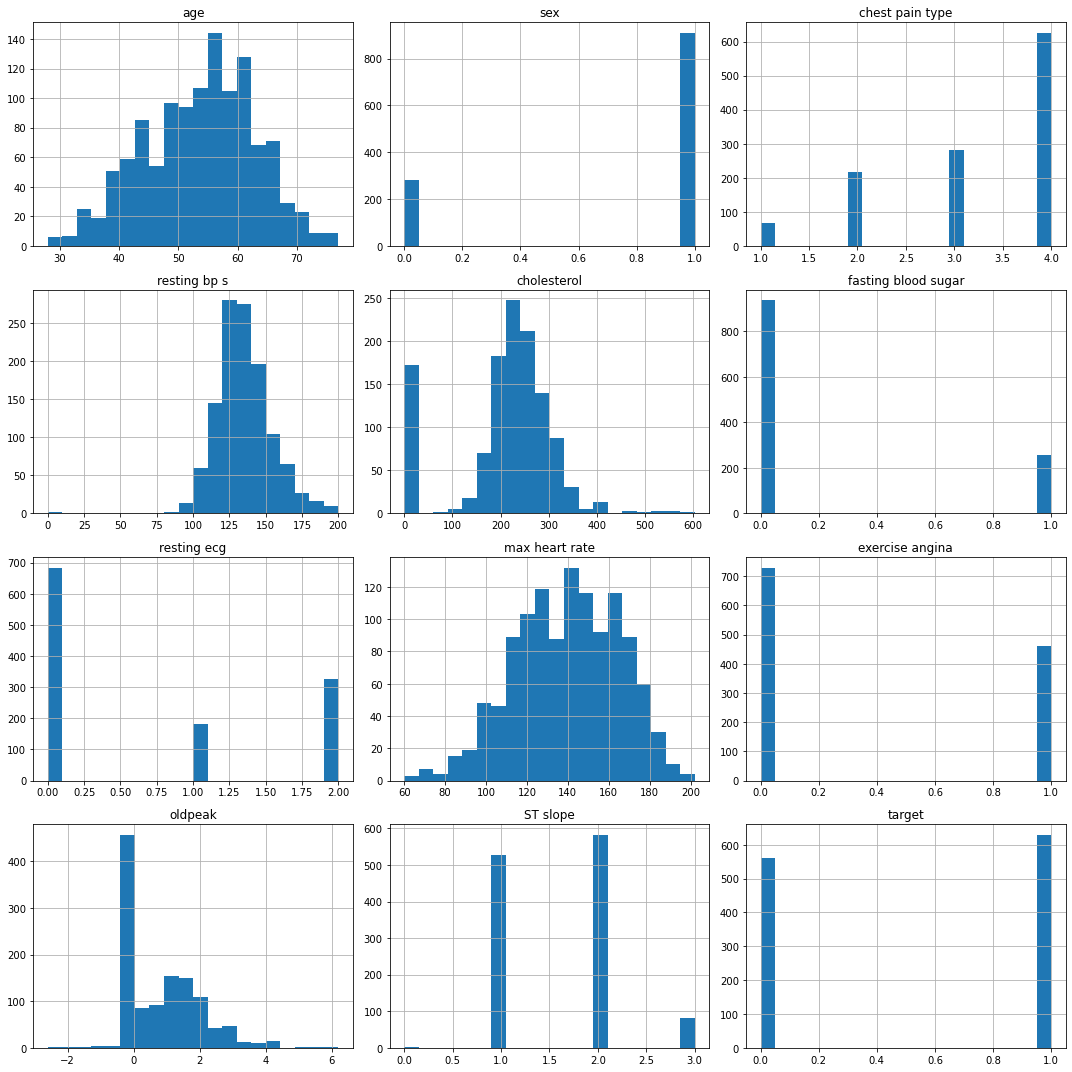

In [22]:
# Plot histograms for all columns for non-modified data so we can see the actual values
data.hist(bins=20, figsize=(15, 15))
plt.tight_layout()
plt.show()

We can see that our data is balanced. In addition, there are no/an insufficient amount of outliers in the data.
Next, we should compare the distributions of the variables between target 0 and target 1 observations

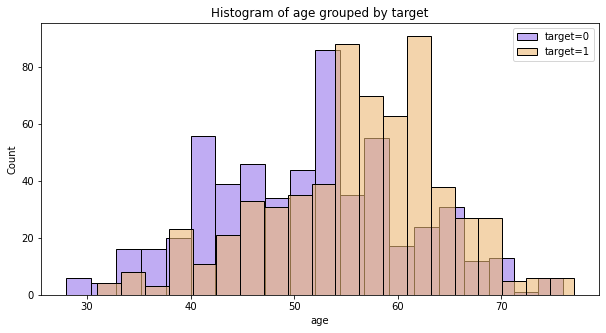

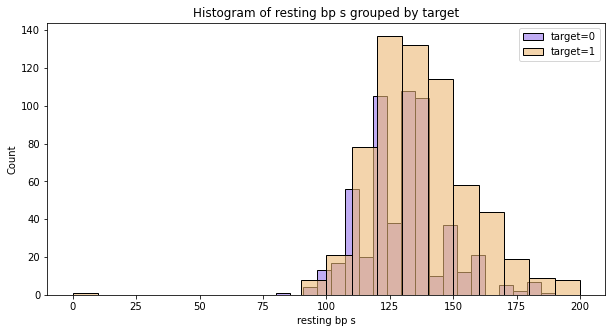

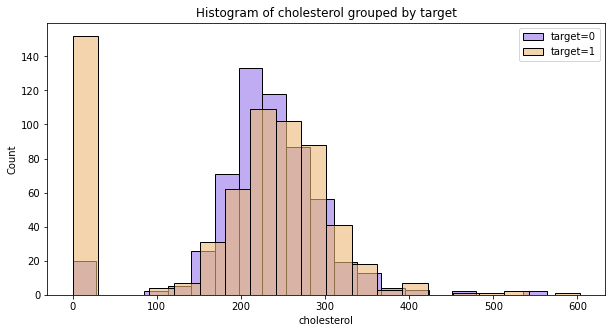

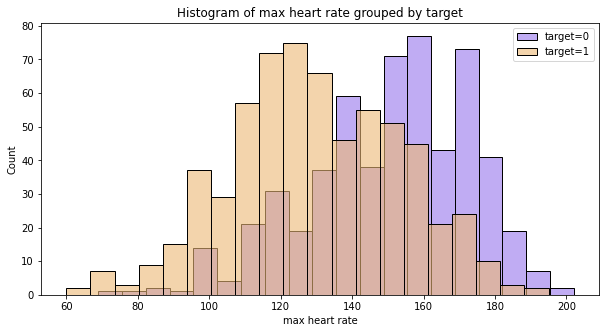

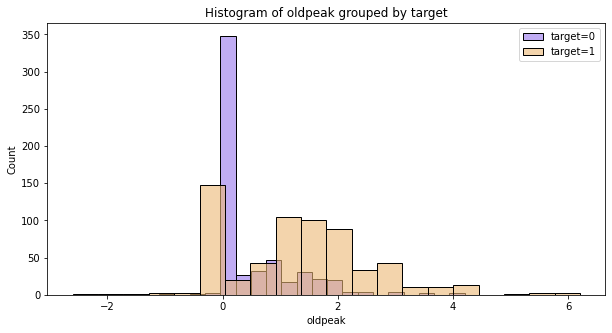

In [49]:
# Plot histograms for numerical columns grouped by target using the original data
numerical_columns = ['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak']

# Create histograms for each numerical column, separated by target values
for column in numerical_columns:
    plt.figure(figsize=(10, 5))
    for target_value, color in zip([0, 1], ['#9775EC', '#ECB875']):
        subset = data[data['target'] == target_value]
        sns.histplot(subset[column], kde=False, bins=20, label=f"target={target_value}", alpha=0.6, color = color)
    plt.title(f"Histogram of {column} grouped by target")
    plt.legend()
    plt.show()

We can see in the numerical data that there is a small difference in distributions for the age and sex variables. We can also see a significant difference in the max heart rate and oldpeak distributions.

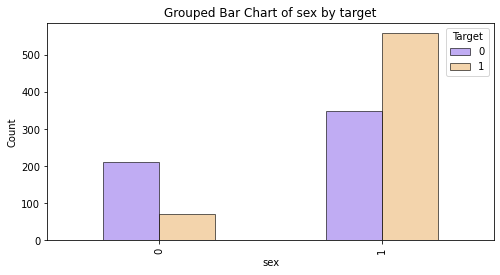

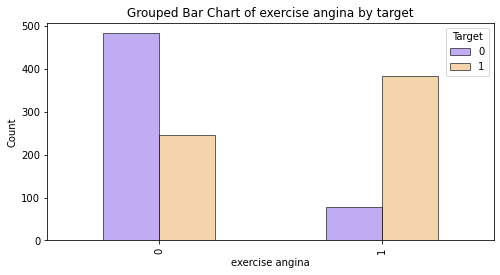

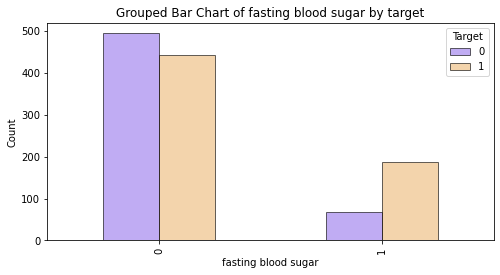

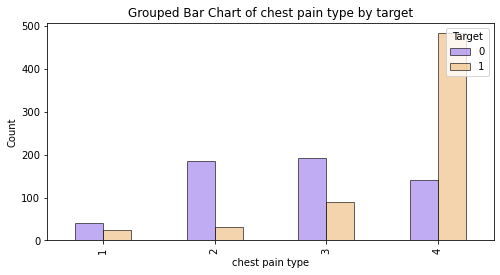

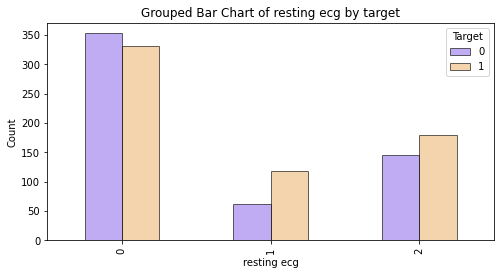

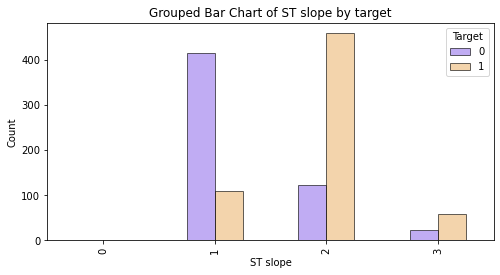

In [51]:
# Plot grouped bar charts for categorical columns grouped by target using hex codes for colors

# Identify categorical columns
categorical_columns = ['sex', 'exercise angina', 'fasting blood sugar', 'chest pain type', 
                       'resting ecg', 'ST slope']

# Define colors for target values
colors = {0: '#9775EC', 1: '#ECB875'}

# Create grouped bar charts for each categorical column, separated by target values
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    counts = data.groupby([column, 'target']).size().unstack().fillna(0)
    counts.plot(kind='bar', stacked=False, color=[colors[0], colors[1]],
                ax=plt.gca(), edgecolor = 'black', alpha = 0.6)
    plt.title(f"Grouped Bar Chart of {column} by target")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.legend(title='Target', loc='upper right')
    plt.show()

We can see notable differences in the grouped bar chart distributions for all variables excluding resting ecg.

In [47]:
# split data for testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features_df, target,
                                                    random_state = 123, test_size = 0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(952, 20)
(952,)
(238, 20)
(238,)
